<DIV ALIGN=CENTER>

# Introduction to Network Analysis: Social Media
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this IPython Notebook, we build on 

-----



-----

### Student Activity

In the preceding cells, we introduced ... . Now
that you have run the Notebook, go back and make the following changes
to see how the results change.

1. Change 
2. Replace 
3. Try using 

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----

## Build co-occurance graph


-----

In [35]:
import tweepy as tw

# Order: Access Token, Access Token Secret, 
# Consumer Key, Consumer SecretAccess
cred_file = '../../Week8/notebooks/twitter.cred'

tokens = []

with open(cred_file, 'r') as fin:
    for line in fin:
        if line[0] != '#': # Not a comment line
            tokens.append(line.rstrip('\n'))

auth = tw.OAuthHandler(tokens[2], tokens[3])
auth.set_access_token(tokens[0], tokens[1])

api = tw.API(auth, 
             wait_on_rate_limit=True, 
             wait_on_rate_limit_notify=True)

user = api.me()

print("Twitter Screen Name: ", user.screen_name)
print("Twitter Follower Count: ", user.followers_count)

Twitter Screen Name:  ProfBrunner
Twitter Follower Count:  149


In [37]:
users = []
tweets = []

results = tw.Cursor(api.search, q='#datascience').items(1000)

#for page in tw.Cursor(api.search, q='data science', rpp=1000).pages():
for result in results:
    users.append(result.user.screen_name)
    tweets.append(result.text)

In [38]:
print(len(tweets))
for result in results:
    print(result.text)

1000


In [185]:
# Print tweet with most hashtags

cnts = [tweet.count('#') for tweet in tweets]

max_cnt = max(cnts)
max_idx = cnts.index(max_cnt)

print('Max hashtags in tweet (count = {0})'.format(cnts[max_idx]))
print(60*'-')
print(tweets[max_idx])

Max hashtags in tweet (count = 10)
------------------------------------------------------------
#BigData #BDaaS #CitizenDataScientist #CDO #cloud #DataLake #Hadoop #DataMining #DataScience #analytics  https://t.co/PMVV9qKxMX


In [78]:
# https://docs.python.org/dev/library/collections.html#collections.Counter
# https://docs.python.org/2/library/itertools.html#itertools.combinations
# https://docs.python.org/3/library/string.html#string.punctuation

from collections import Counter
from itertools import combinations
import string

tkns = set()
cnt = Counter()

# Iterate over all tweets
for tweet in tweets:
    
    # First, we use a list comprehension that extract hashtags
    # We strip off leading '#', then remove trailing punctuation.
    # And turn all characters to lowercase.
    # Note this is not Unicode clean.
    # Finally, we sort the list of tags (which will ensure the
    # Counter works correctly)
    
    tags = sorted([tag.lstrip("#").rstrip(string.punctuation).lower() 
            for tag in tweet.split() if tag.startswith("#")])
    
    # We now build our set of tokens
    
    for tag in tags:
        tkns.add(tag)
            
    # Next we use combinations from the itertools library 
    # to make a list of tag pairs. 
    # We then increment the counter for each paried tag

    for paired_tags in combinations(tags, 2):
        cnt[paired_tags] += 1

# How many hashtags did we extract?
print('Total number of unique hashtags = {0}'.format(len(tkns)))

# Extract the top pair, list of tuples (pair, count)
mc = cnt.most_common(1)[0]
print('Total number of paired tags = {0}'.format(len(cnt)))
print('Most common pair = {0}, occurs {1} times.'.format(mc[0], mc[1]))

Total number of unique hashtags = 311
Total number of paired tags = 967
Most common pair = ('bigdata', 'datascience'), occurs 407 times.


In [85]:
# Now we go through pair counter for top pairs to build network.

tkns = set()
num_top_pairs = 25

top_pairs = cnt.most_common(num_top_pairs)

for pair, count in top_pairs:
    tkns.add(pair[0])
    tkns.add(pair[1])

print('Total number of unique hashtags = {0}\n'.format(len(tkns)))
print('Hashtags to graph:')
print(40*'-')
print(tkns)

Total number of unique hashtags = 13

Hashtags:
----------------------------------------
{'machinelearning', 'deeplearning', 'cybersecurity', 'datasecurity', 'security', 'ai', 'bigdata', 'datascience', 'iot', 'analytics', 'rstats', 'data', 'abdsc'}


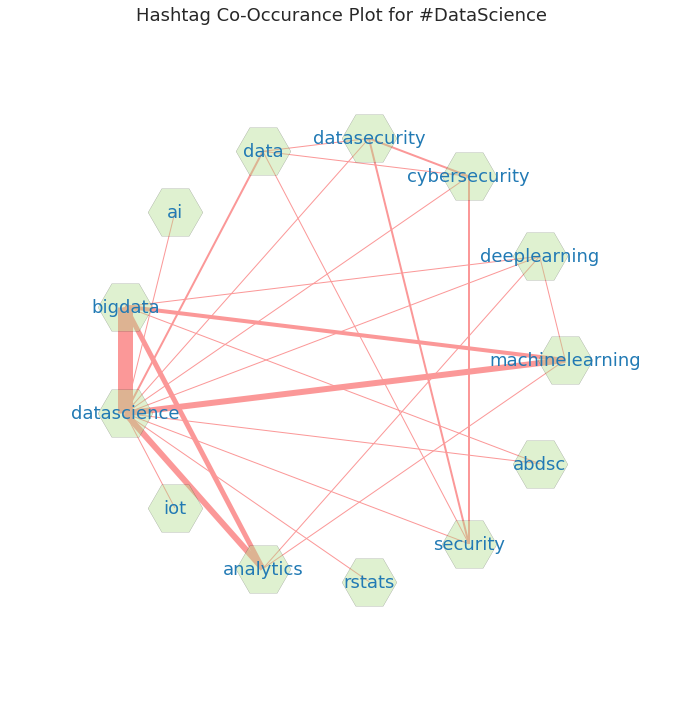

In [180]:
# First setup the current figure. 
# No axes, no Axes labels, white background

fig, axes = plt.subplots(figsize=(12, 12))

clrs = sns.color_palette("Paired")

sns.set(style='white', font_scale=1.5)

sns.despine(top = True, bottom = True, 
            left = True, right = True)

axes.set_xticklabels([])
axes.set_yticklabels([])

# Build graph

import networkx as nx

g = nx.Graph()

g.add_nodes_from(list(tkns))

for pair, count in top_pairs:
    g.add_edge(pair[0], pair[1], weight=count)

# Now draw graph, use circular layout

pos = nx.circular_layout(g)

nx.draw_networkx_nodes(g, pos, with_labels=True,
                       node_size = 3000,
                       node_color=clrs[2],
                       node_shape='H',
                       alpha = 0.4)

# Build up list of edges and weights for controlled plotting
edges = []
weights = []

for n1, n2, dct in g.edges(data=True):
    edges.append((n1, n2))
    weights.append(dct['weight'])

# Make nromalized weights (scale to minimum weight)
min_weight = min(weights)
norm_weights = [int(weight/min_weight) for weight in weights]

# Draw weighted edges
nx.draw_networkx_edges(g, pos, edgelist=edges, 
                       width = norm_weights, 
                       edge_color=clrs.as_hex()[4],
                       alpha = 1.0)

# Now label nodes
nx.draw_networkx_labels(g, pos, font_size = 18,
                        font_color = clrs[1],
                        alpha = 1.0)

plt.title('Hashtag Co-Occurance Plot for #DataScience')
plt.show()